### Loading data - CIFAR10

In [65]:
import torch
import torchvision
import torchvision.transforms as transforms

In [66]:
"""
torchvision.datasets returns PILimages (Python Imaging Library) of range [0,1]. We now 
transform them into Tensors of normalized range [-1,1]. Why PIL previously? This enables 
us to display images onto the screen, but to perform computations using an NN, we need to 
transform them into PyTorch Tensors. 
transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)) - the first set of 0.5's indicate 
the mean for 3 color channels -- RGB. The second set of 0.5's indicate the standard deviation. 
-- These are per-channel mean/stds.

Normalize does the following for each channel:

image = (image - mean) / std

The parameters mean, std are passed as 0.5, 0.5 in this case. This will normalize the image 
in the range [-1,1]. 
For example, the minimum value 0 will be converted to (0-0.5)/0.5=-1, the maximum value of 1 
will be converted to (1-0.5)/0.5=1.
Why [-1,1] and why not [0,1]? [-1,1] gives a better accuracy of the model.

"""
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

"""
num_workers (int, optional) – how many subprocesses to use for data loading. 0 means that the 
data will be loaded in the main process. (default: 0)

"""
trainset = torchvision.datasets.CIFAR10(root='./datasets/',train=True, download=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle = True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./datasets/', train=False, download=True, transform=transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [67]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

ship frog deer plane horse


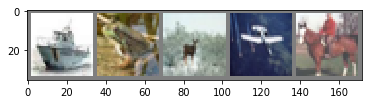

In [68]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(image):
    image = image/2 + 0.5 # Un-normalizing
    numpy_image = image.numpy()
    """
    The dimensions will be changed.
    In PyTorch, the order of dimension is channel*width*height but in matplotlib 
    it’s width*height*channel. 
    That’s why the transpose is needed. -- the first dimension will be placed as the 3rd arg.
    Second dimension as first arg.
    Third dimension as second arg.
    
    """
    plt.imshow(np.transpose(numpy_image,(1,2,0)))

# Random training images -- a batch of 8 images
dataiter = iter(trainLoader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# show labels
print(' '.join('%4s' % classes[labels[j]] for j in range(5)))

### CNN

In [72]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 4)
        self.fc1 = nn.Linear(128 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 10)

    # Pooling can either be defined as a function or as a layer. Anything can be done!
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


net = Net()

### Loss and Optimizer

In [73]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.8)

### Training phase

In [74]:
# 6000 batches -- 50000(total number of images in the trainset)/5(batch_size) = 10000 
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainLoader,0):
        images, labels = data
        optimizer.zero_grad()
        out = net(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i%2000 == 1999:
            print('[%d %5d] loss=%.3f' % (epoch+1, i+1, running_loss/2000)) # printing loss per image -- avg loss
            running_loss =0.0
print('Done training!')

[1  2000] loss=2.285
[1  4000] loss=2.010
[1  6000] loss=1.776
[1  8000] loss=1.658
[1 10000] loss=1.566
[2  2000] loss=1.454
[2  4000] loss=1.401
[2  6000] loss=1.350
[2  8000] loss=1.303
[2 10000] loss=1.254
[3  2000] loss=1.192
[3  4000] loss=1.145
[3  6000] loss=1.103
[3  8000] loss=1.090
[3 10000] loss=1.027
[4  2000] loss=0.960
[4  4000] loss=0.950
[4  6000] loss=0.924
[4  8000] loss=0.932
[4 10000] loss=0.900
[5  2000] loss=0.805
[5  4000] loss=0.810
[5  6000] loss=0.783
[5  8000] loss=0.782
[5 10000] loss=0.761
Done training!


### Testing phase

 cat ship ship plane frog


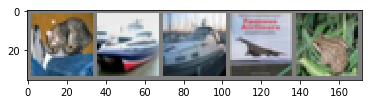

In [75]:
dataiter = iter(testLoader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# show labels
print(' '.join('%4s' % classes[labels[j]] for j in range(5)))

In [76]:
outputs = net(images)
print(type(outputs))

<class 'torch.Tensor'>


In [77]:
outputs

tensor([[ 0.2919, -1.8117, -0.0445,  3.8632, -1.0957,  1.9138,  0.5646, -2.5407,
          1.6533, -2.1902],
        [ 5.1976,  7.0596, -1.3874, -0.9124, -5.5242, -4.4233, -3.2314, -6.8318,
          9.6726,  3.1701],
        [ 2.8081,  3.5240, -0.5491, -0.2909, -2.2149, -2.2391, -1.6160, -2.6184,
          3.4626,  1.0756],
        [ 6.8319,  2.6141,  0.8498, -0.9237, -2.5095, -3.7145, -1.7075, -4.0750,
          4.2288, -0.2787],
        [-4.3006, -4.0533,  3.4027,  4.1486,  4.8351,  2.3775,  6.0254, -2.5893,
         -3.8041, -5.5268]], grad_fn=<ThAddmmBackward>)

In [78]:
_,predicted = torch.max(outputs, 1) # 1 -- is the number of axes -- 1D, _ -- is the max value, predicted -- 
# arrays of indices
print('Predicted classes: ',' '.join('%5s' % classes[predicted[j]] for j in range(5)))

Predicted classes:    cat  ship   car plane  frog


### Accuracy

In [79]:
correct = 0
total = 0
# Deactivates the autograd engine and reduces the memory consumption
with torch.no_grad():
    for data in testLoader:
        images, labels = data
        output = net(images)
        _,predicted = torch.max(output,1)
        total += labels.size(0) # 5 -- labels.size(0)
        # sum() returns a single values tensor indicating the number of rightly labelled values
        # item() returns the val in the above tensor.
        correct += (predicted==labels).sum().item() 

print('Accuracy on 10000 test images: %d %%' %((correct * 100)/total))

Accuracy on 10000 test images: 71 %


In [82]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testLoader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        # c returns a tensor of 1's and 0's -- correctly and incorrectly labelled images
        c = (predicted == labels)
        for i in range(5):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 81 %
Accuracy of   car : 89 %
Accuracy of  bird : 58 %
Accuracy of   cat : 64 %
Accuracy of  deer : 64 %
Accuracy of   dog : 55 %
Accuracy of  frog : 76 %
Accuracy of horse : 74 %
Accuracy of  ship : 80 %
Accuracy of truck : 65 %
